# 风险平价策略实现
本Notebook实现了基于风险平价的资产配置策略，主要包括以下步骤：
1. 数据加载与预处理
2. 计算对数收益率
3. 滚动再平衡策略的实现
4. 资产权重的可视化
5. 绩效指标的计算与分析

In [1]:
# 导入必要的库
import riskparityportfolio as rp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

## 数据加载与预处理
加载资产数据并进行必要的预处理，包括日期格式转换和数据清洗。

In [2]:
# 加载资产数据
assets = pd.read_csv('data/assets V2.csv', encoding='utf-8-sig')
assets['日期'] = pd.to_datetime(assets['日期'])  # 转换日期格式
assets = assets.iloc[:, :-1]  # 暂时排除十年国债期货列

## 资产池：沪金、权益和债券ETF

### 计算对数收益率
对资产价格数据计算对数收益率，作为后续分析的基础。

In [3]:
# 计算所有时间段的对数收益率
all_log_returns = assets.set_index('日期').apply(lambda x: np.log(x / x.shift(1))).fillna(0)
all_log_returns

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,海富通上证城投债ETF,平安中证5-10年国债活跃券ETF,平安中债债利差因子ETF,沪金主连
日期,,,,,,,
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-02,-0.001932,0.005526,-0.000904,-0.000127,0.000000,-0.003139,0.000177
2019-04-03,0.014535,0.007984,0.014363,0.000000,-0.001204,-0.002269,0.002655
2019-04-04,0.012715,0.005452,0.015477,0.000255,-0.002303,0.003976,0.000177
2019-04-08,-0.007014,-0.009436,0.006560,-0.001531,-0.003024,-0.003873,0.004232
...,...,...,...,...,...,...,...
2025-04-07,-0.069011,-0.105271,-0.059142,0.002440,0.003723,0.002460,-0.028632
2025-04-08,0.009428,-0.006737,0.021883,-0.001658,-0.001826,-0.001722,0.001447
2025-04-09,0.009605,0.017423,0.001331,-0.000781,-0.000735,0.000038,0.012326


### 滚动再平衡策略
实现滚动再平衡策略，计算每个再平衡周期的资产权重和组合收益。

In [4]:
# 初始化滚动再平衡策略的变量
rolling_cumulative_returns = [1]  # 初始累计收益为1
rolling_monthly_returns = []  # 存储每月的非累计收益
rolling_weights = []  # 存储每个再平衡周期的权重
start_date = assets['日期'].min() + pd.DateOffset(years=1)  # 再平衡的起始日期
end_date = assets['日期'].max()  # 数据的结束日期
current_date = start_date  # 当前日期初始化为起始日期
budget = [0.111111111] * 6  # 风险预算分配
budget.append(0.333333333)
balancing_dates = []  # 存储再平衡日期

In [5]:
# 执行滚动月度再平衡
while current_date <= end_date:
    balancing_dates.append(current_date)  # 记录再平衡日期
    # 定义回溯期（过去1年）
    lookback_start = current_date - pd.DateOffset(years=1)

    # 计算回溯期的协方差矩阵
    lookback_log_returns = all_log_returns.loc[lookback_start:current_date - pd.Timedelta(days=1)]
    lookback_cov_matrix = lookback_log_returns.cov()
    sigma_lookback = np.array(lookback_cov_matrix)

    # 计算回溯期的风险平价权重
    portfolio_lookback = rp.RiskParityPortfolio(covariance=sigma_lookback, budget=budget)
    portfolio_lookback.design()
    weights_lookback = portfolio_lookback.weights
    rolling_weights.append(weights_lookback)

    # 计算当前月的组合收益
    current_month_data = assets[(assets['日期'] >= current_date) & (assets['日期'] < current_date + pd.DateOffset(months=1))]
    current_month_log_returns = all_log_returns.loc[current_date:current_date + pd.DateOffset(months=1) - pd.Timedelta(days=1)]
    current_month_portfolio_returns = current_month_log_returns.dot(weights_lookback)

    # 更新累计收益和非累计收益
    for ret in current_month_portfolio_returns:
        rolling_monthly_returns.append(ret)  # 添加非累计收益
        rolling_cumulative_returns.append(rolling_cumulative_returns[-1] * (1 + ret))

    # 移动到下一个月
    current_date += pd.DateOffset(months=1)

  0%|          | 1/500 [00:00<00:23, 21.28it/s]


### 可视化资产权重
使用堆叠柱状图展示资产权重随时间的变化。

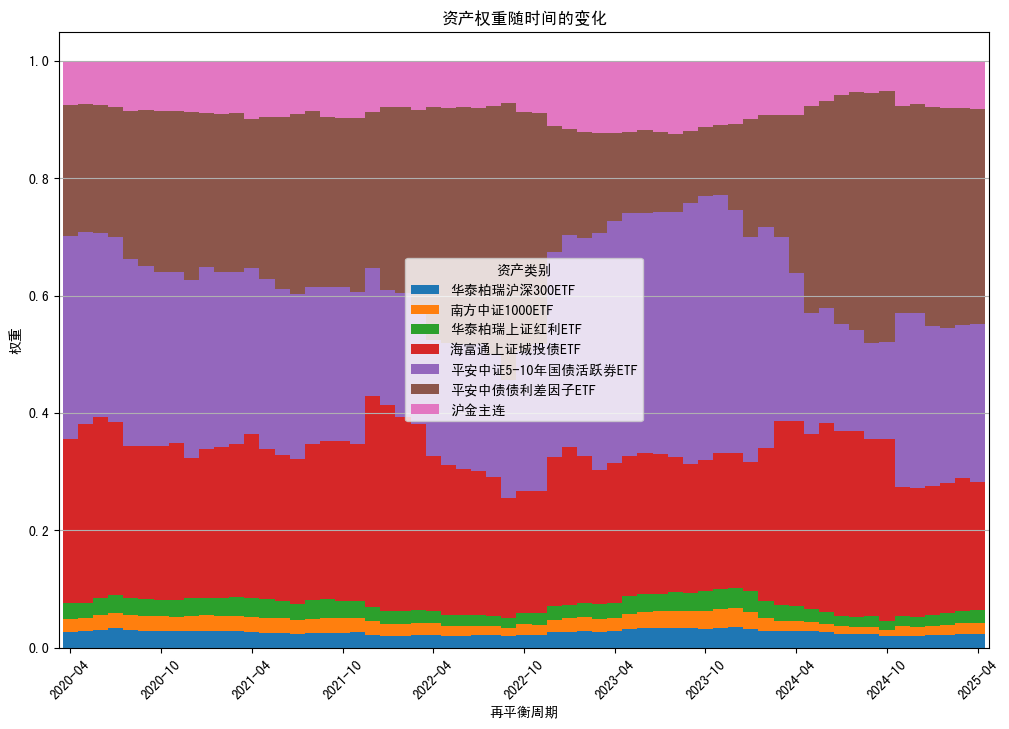

In [6]:
# 将滚动权重转换为DataFrame并设置索引为再平衡日期
rolling_weights = pd.DataFrame(rolling_weights, columns=all_log_returns.columns)
rolling_weights.index = balancing_dates

# 使用堆叠柱状图可视化资产权重随时间的变化
plt.rcParams['font.family'] = 'SimHei'  # 设置中文字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

rolling_weights.plot(kind='bar', stacked=True, figsize=(12, 8), width=1)

plt.title('资产权重随时间的变化')
plt.xlabel('再平衡周期')
plt.ylabel('权重')
plt.legend(title='资产类别')
plt.grid(axis='y')

# 调整x轴刻度以显示每隔n个标签
plt.xticks(ticks=range(0, len(rolling_weights.index), 6), labels=rolling_weights.index[::6].strftime('%Y-%m'), rotation=45)

plt.show()

In [7]:
# 将非累计收益转换为pandas Series
rolling_monthly_returns = pd.Series(rolling_monthly_returns, index=all_log_returns.loc[start_date:].index)
rolling_monthly_returns

日期
2020-04-01    0.000926
2020-04-02    0.003006
2020-04-03   -0.000249
2020-04-07    0.004960
2020-04-08   -0.000305
                ...   
2025-04-07   -0.004841
2025-04-08   -0.000800
2025-04-09    0.001248
2025-04-10    0.003505
2025-04-11    0.001608
Length: 1219, dtype: float64

In [8]:
# Convert rolling cumulative returns to a pandas Series
rolling_cumulative_returns = pd.Series(
    rolling_cumulative_returns[1:],  # Exclude the initial value
    index=all_log_returns.loc[start_date: ].index  # Match index length
)

In [9]:
rolling_cumulative_returns

日期
2020-04-01    1.000926
2020-04-02    1.003935
2020-04-03    1.003684
2020-04-07    1.008662
2020-04-08    1.008354
                ...   
2025-04-07    1.240660
2025-04-08    1.239668
2025-04-09    1.241215
2025-04-10    1.245565
2025-04-11    1.247567
Length: 1219, dtype: float64

In [10]:
# 复制对数收益率并添加组合收益列
log_returns = all_log_returns.loc[start_date: ].copy()
log_returns['portfolio'] = rolling_monthly_returns
log_returns

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,海富通上证城投债ETF,平安中证5-10年国债活跃券ETF,平安中债债利差因子ETF,沪金主连,portfolio
日期,,,,,,,,
2020-04-01,0.001180,-0.003176,-0.009127,0.002734,0.005096,0.000000,-0.017360,0.000926
2020-04-02,0.014629,0.025649,0.014790,-0.002258,0.002548,0.004310,0.005783,0.003006
2020-04-03,-0.007580,-0.006741,-0.003960,0.000951,-0.002548,0.001075,0.007678,-0.000249
2020-04-07,0.024000,0.036275,0.019647,-0.000713,0.003035,0.000000,0.028211,0.004960
2020-04-08,-0.004295,0.001504,0.000556,0.000832,0.002025,-0.001881,-0.009891,-0.000305
...,...,...,...,...,...,...,...,...
2025-04-07,-0.069011,-0.105271,-0.059142,0.002440,0.003723,0.002460,-0.028632,-0.004841
2025-04-08,0.009428,-0.006737,0.021883,-0.001658,-0.001826,-0.001722,0.001447,-0.000800
2025-04-09,0.009605,0.017423,0.001331,-0.000781,-0.000735,0.000038,0.012326,0.001248


In [11]:
# 计算每个资产类别和组合的累计收益
cumulative_returns_assets = (1 + log_returns).cumprod()
cumulative_returns_assets['portfolio'] = rolling_cumulative_returns
cumulative_returns_assets

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,海富通上证城投债ETF,平安中证5-10年国债活跃券ETF,平安中债债利差因子ETF,沪金主连,portfolio
日期,,,,,,,,
2020-04-01,1.001180,0.996824,0.990873,1.002734,1.005096,1.000000,0.982640,1.000926
2020-04-02,1.015826,1.022391,1.005528,1.000470,1.007657,1.004310,0.988323,1.003935
2020-04-03,1.008125,1.015499,1.001545,1.001422,1.005089,1.005390,0.995911,1.003684
2020-04-07,1.032320,1.052336,1.021223,1.000707,1.008139,1.005390,1.024006,1.008662
2020-04-08,1.027887,1.053919,1.021790,1.001540,1.010181,1.003498,1.013877,1.008354
...,...,...,...,...,...,...,...,...
2025-04-07,0.992849,1.014013,1.523862,1.219389,1.196970,1.140652,1.891861,1.240660
2025-04-08,1.002209,1.007181,1.557208,1.217367,1.194785,1.138688,1.894598,1.239668
2025-04-09,1.011836,1.024729,1.559281,1.216415,1.193907,1.138731,1.917951,1.241215


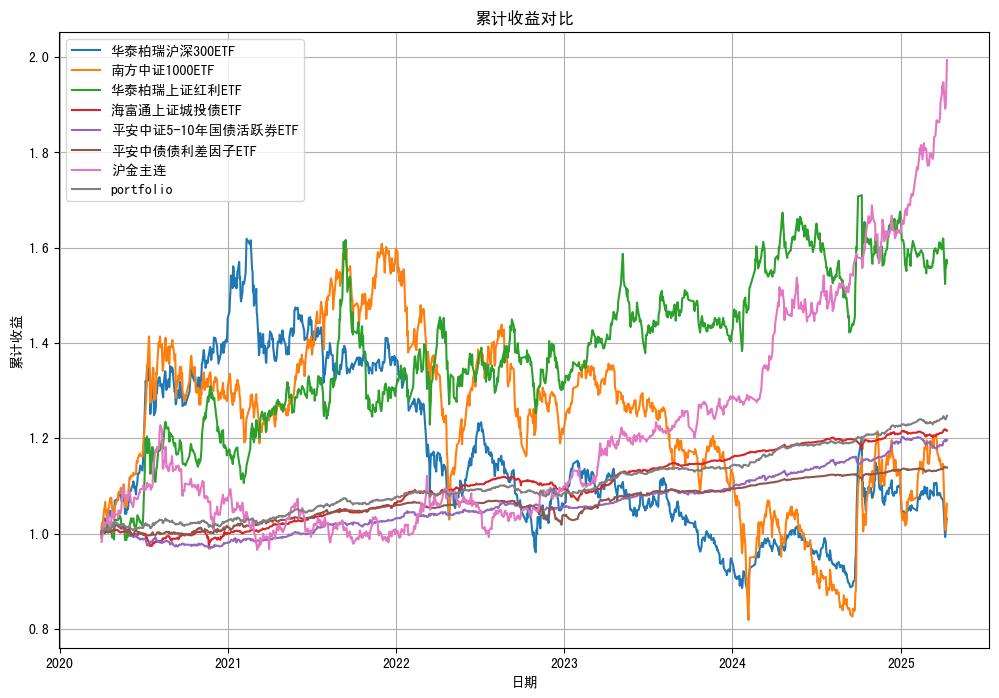

In [12]:
# 绘制每个资产类别和组合的累计收益对比图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for column in cumulative_returns_assets.columns:
    plt.plot(cumulative_returns_assets.index, cumulative_returns_assets[column], label=column)

plt.title('累计收益对比')
plt.xlabel('日期')
plt.ylabel('累计收益')
plt.legend()
plt.grid()
plt.show()

### 绩效指标计算
计算组合的绩效指标，包括夏普比率、最大回撤、年化收益和Calmar比率。

In [13]:
# 定义函数以计算组合绩效指标
def calculate_metrics(log_returns, cumulative_returns, risk_free_rate):
    sharpe_ratio = (log_returns.mean() - risk_free_rate) / log_returns.std() * np.sqrt(252)  # 夏普比率
    rolling_max = cumulative_returns.cummax()  # 滚动最大值
    drawdown = (cumulative_returns - rolling_max) / rolling_max  # 回撤
    max_drawdown = drawdown.min()  # 最大回撤
    total_return = cumulative_returns.iloc[-1] - 1  # 总收益
    num_years = len(cumulative_returns) / 252  # 年数
    annualized_return = (1 + total_return) ** (1 / num_years) - 1  # 年化收益
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else float('inf')  # Calmar比率
    return sharpe_ratio, max_drawdown, annualized_return, calmar_ratio

In [14]:
# 定义无风险利率（例如1.5%年化）
risk_free_rate = 0.015 / 252

# 计算每个资产和组合的绩效指标
metrics = []
for column in cumulative_returns_assets.columns:
    sharpe_ratio, max_drawdown, annualized_return, calmar_ratio = calculate_metrics(
        log_returns[column], cumulative_returns_assets[column], risk_free_rate
    )
    metrics.append({
        '资产': column,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        '年化收益': annualized_return,
        'Calmar比率': calmar_ratio
    })

# 将指标转换为DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,资产,夏普比率,最大回撤,年化收益,Calmar比率
0,华泰柏瑞沪深300ETF,0.054944,-0.456219,0.006447,0.014131
1,南方中证1000ETF,0.116291,-0.490943,0.012693,0.025854
2,华泰柏瑞上证红利ETF,0.498997,-0.239741,0.097370,0.406148
3,海富通上证城投债ETF,1.057127,-0.044794,0.041331,0.922681
4,平安中证5-10年国债活跃券ETF,0.909808,-0.054111,0.037797,0.698511
5,平安中债债利差因子ETF,0.462171,-0.047365,0.027219,0.574666
6,沪金主连,1.060047,-0.213090,0.153349,0.719645
7,portfolio,1.382957,-0.021263,0.046789,2.200423


## 利用杠杆放大债券ETF收益
杠杆率上限是140%；不考虑杠杆资金成本

In [15]:
# 开放式公募基金或理财产品的杠杆率上限是140%
all_log_returns[['海富通上证城投债ETF', '平安中证5-10年国债活跃券ETF', '平安中债债利差因子ETF']] = all_log_returns[['海富通上证城投债ETF', '平安中证5-10年国债活跃券ETF', '平安中债债利差因子ETF']] * 1.4  # 未考虑杠杆成本

In [16]:
all_log_returns

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,海富通上证城投债ETF,平安中证5-10年国债活跃券ETF,平安中债债利差因子ETF,沪金主连
日期,,,,,,,
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-02,-0.001932,0.005526,-0.000904,-0.000178,0.000000,-0.004394,0.000177
2019-04-03,0.014535,0.007984,0.014363,0.000000,-0.001686,-0.003177,0.002655
2019-04-04,0.012715,0.005452,0.015477,0.000357,-0.003224,0.005566,0.000177
2019-04-08,-0.007014,-0.009436,0.006560,-0.002143,-0.004234,-0.005423,0.004232
...,...,...,...,...,...,...,...
2025-04-07,-0.069011,-0.105271,-0.059142,0.003416,0.005212,0.003445,-0.028632
2025-04-08,0.009428,-0.006737,0.021883,-0.002322,-0.002556,-0.002410,0.001447
2025-04-09,0.009605,0.017423,0.001331,-0.001094,-0.001028,0.000053,0.012326


In [17]:
# Initialize variables for rolling rebalancing strategy
# 初始化滚动再平衡策略的变量
rolling_cumulative_returns = [1]  # 初始累计收益为1
rolling_monthly_returns = []  # 存储每月的非累计收益
rolling_weights = []  # 存储每个再平衡周期的权重
start_date = assets['日期'].min() + pd.DateOffset(years=1)  # 再平衡的起始日期
end_date = assets['日期'].max()  # 数据的结束日期
current_date = start_date  # 当前日期初始化为起始日期
budget = [0.111111111] * 6
budget.append(0.333333333)  # 风险预算
balancing_dates = []  # 存储再平衡日期

In [18]:
# Perform rolling monthly rebalancing
while current_date <= end_date:
    balancing_dates.append(current_date)  # 记录再平衡日期
    # Define the lookback period (past 1 year)
    lookback_start = current_date - pd.DateOffset(years=1)

    # Calculate covariance matrix for the lookback period
    lookback_log_returns = all_log_returns.loc[lookback_start:current_date - pd.Timedelta(days=1)]
    lookback_cov_matrix = lookback_log_returns.cov()
    sigma_lookback = np.array(lookback_cov_matrix)

    # Calculate risk parity weights for the lookback period
    portfolio_lookback = rp.RiskParityPortfolio(covariance=sigma_lookback, budget=budget)
    portfolio_lookback.design()
    weights_lookback = portfolio_lookback.weights
    rolling_weights.append(weights_lookback)

    # Calculate portfolio returns for the current month
    current_month_data = assets[(assets['日期'] >= current_date) & (assets['日期'] < current_date + pd.DateOffset(months=1))]
    current_month_log_returns = all_log_returns.loc[current_date:current_date + pd.DateOffset(months=1) - pd.Timedelta(days=1)]
    current_month_portfolio_returns = current_month_log_returns.dot(weights_lookback)

    # 更新累计收益和非累计收益
    for ret in current_month_portfolio_returns:
        rolling_monthly_returns.append(ret)  # 添加非累计收益
        rolling_cumulative_returns.append(rolling_cumulative_returns[-1] * (1 + ret))

    # Move to the next month
    current_date += pd.DateOffset(months=1)

  0%|          | 1/500 [00:00<00:17, 27.85it/s]


In [19]:
# 将滚动权重转换为DataFrame并设置索引为再平衡日期
rolling_weights = pd.DataFrame(rolling_weights, columns=all_log_returns.columns)
rolling_weights.index = balancing_dates
rolling_weights

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,海富通上证城投债ETF,平安中证5-10年国债活跃券ETF,平安中债债利差因子ETF,沪金主连
2020-04-01,0.035435,0.029526,0.035048,0.264360,0.324934,0.210732,0.099966
2020-05-01,0.036491,0.029181,0.035231,0.287208,0.308644,0.205674,0.097572
2020-06-01,0.040050,0.032476,0.038549,0.289572,0.296247,0.204978,0.098129
2020-07-01,0.042965,0.033472,0.040809,0.277216,0.295049,0.207863,0.102627
2020-08-01,0.038991,0.034149,0.037727,0.242922,0.298400,0.235894,0.111917
...,...,...,...,...,...,...,...
2024-12-01,0.026524,0.020133,0.022910,0.208934,0.284879,0.338283,0.098338
2025-01-01,0.027856,0.020500,0.024390,0.209040,0.259593,0.354559,0.104062
2025-02-01,0.029317,0.022194,0.026016,0.209791,0.251374,0.354385,0.106923
2025-03-01,0.030332,0.025038,0.027894,0.213219,0.247378,0.349660,0.106478


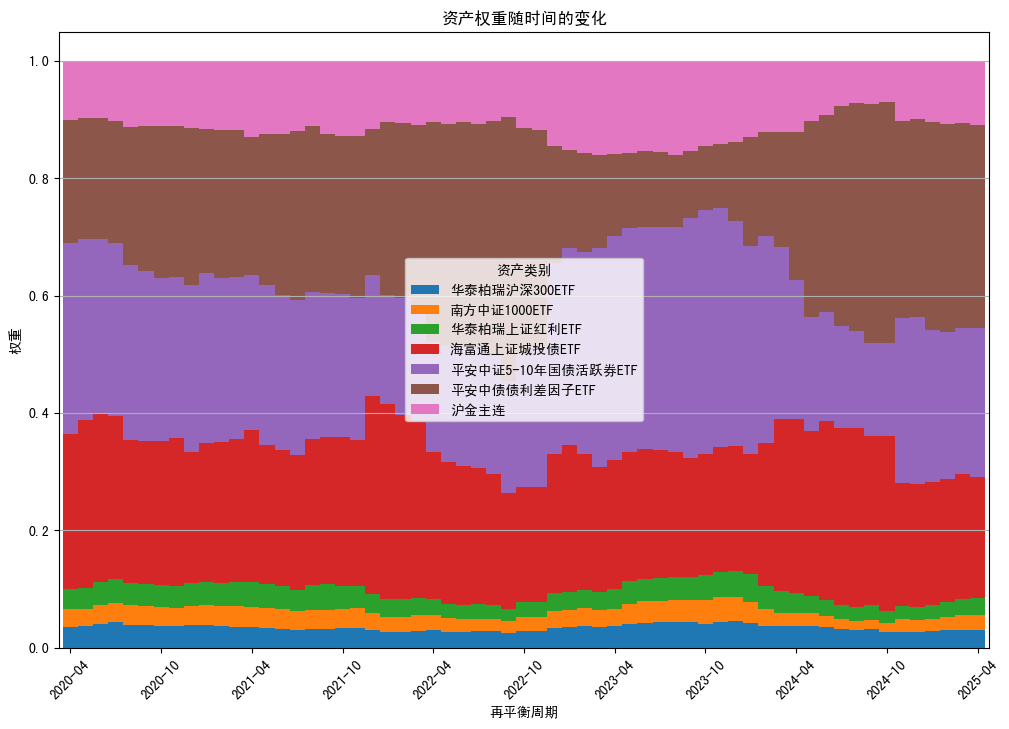

In [20]:
# 使用堆叠柱状图可视化资产权重随时间的变化
# Visualize the correlation matrix
plt.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

rolling_weights.plot(kind='bar', stacked=True, figsize=(12, 8), width=1)

plt.title('资产权重随时间的变化')
plt.xlabel('再平衡周期')
plt.ylabel('权重')
plt.legend(title='资产类别')
plt.grid(axis='y')

# 调整x轴刻度以显示每隔n个标签
plt.xticks(ticks=range(0, len(rolling_weights.index), 6), labels=rolling_weights.index[::6].strftime('%Y-%m'), rotation=45)

plt.show()

In [21]:
rolling_monthly_returns = pd.Series(rolling_monthly_returns, index=all_log_returns.loc[start_date:].index)

# Convert rolling cumulative returns to a pandas Series
rolling_cumulative_returns = pd.Series(
    rolling_cumulative_returns[1:],  # Exclude the initial value
    index=all_log_returns.loc[start_date: ].index  # Match index length
)

log_returns = all_log_returns.loc[start_date: ].copy()
log_returns['portfolio'] = rolling_monthly_returns

cumulative_returns_assets = (1 + log_returns).cumprod()
cumulative_returns_assets['portfolio'] = rolling_cumulative_returns

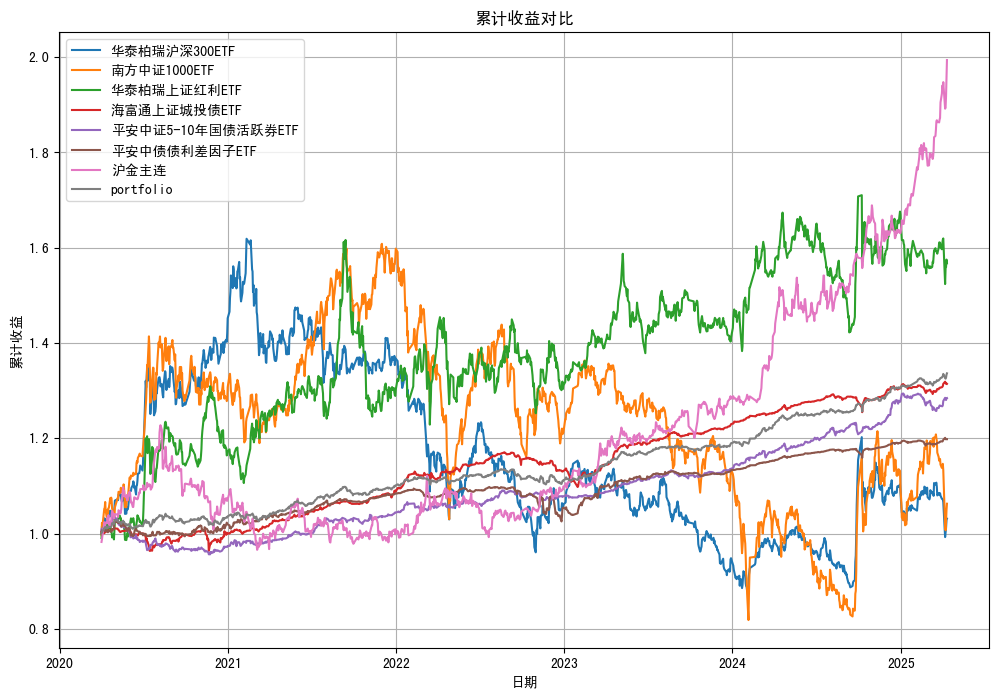

In [22]:
# 绘制每个资产类别和组合的累计收益对比图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for column in cumulative_returns_assets.columns:
    plt.plot(cumulative_returns_assets.index, cumulative_returns_assets[column], label=column)

plt.title('累计收益对比')
plt.xlabel('日期')
plt.ylabel('累计收益')
plt.legend()
plt.grid()
plt.show()

In [23]:
# 定义无风险利率（例如1.5%年化）
risk_free_rate = 0.015 / 252

# 计算每个资产和组合的绩效指标
metrics = []
for column in cumulative_returns_assets.columns:
    sharpe_ratio, max_drawdown, annualized_return, calmar_ratio = calculate_metrics(
        log_returns[column], cumulative_returns_assets[column], risk_free_rate
    )
    metrics.append({
        '资产': column,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        '年化收益': annualized_return,
        'Calmar比率': calmar_ratio
    })

# 将指标转换为DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,资产,夏普比率,最大回撤,年化收益,Calmar比率
0,华泰柏瑞沪深300ETF,0.054944,-0.456219,0.006447,0.014131
1,南方中证1000ETF,0.116291,-0.490943,0.012693,0.025854
2,华泰柏瑞上证红利ETF,0.498997,-0.239741,0.097370,0.406148
3,海富通上证城投债ETF,1.232725,-0.062247,0.058159,0.934328
4,平安中证5-10年国债活跃券ETF,1.083831,-0.075068,0.053133,0.707795
5,平安中债债利差因子ETF,0.624466,-0.065974,0.038109,0.577641
6,沪金主连,1.060047,-0.213090,0.153349,0.719645
7,portfolio,1.540419,-0.028200,0.061799,2.191464


## 国债期货
国债期货可以利用杠杆放大债券资产的收益。
由于仅有国债期货，无法考虑信用债等资产。
2年期国债期货：保证金比例为 0.5%，杠杆倍数约为 200 倍。      
5年期国债期货：保证金比例为 1.2%，杠杆倍数约为 83 倍。    
10年期国债期货：保证金比例为 2%，杠杆倍数约为 50 倍。      
30年期国债期货：保证金比例可能为合约价值的 3%-5%，杠杆倍数大约在 20 倍至 33 倍之间。    

In [24]:
 # Load asset data
assets = pd.read_csv('data/assets V2.csv', encoding='utf-8-sig')
assets['日期'] = pd.to_datetime(assets['日期']) 
assets = assets.drop(['海富通上证城投债ETF', '平安中证5-10年国债活跃券ETF', '平安中债债利差因子ETF'], axis=1)  # 用国债期货代替债券ETF
assets

,日期,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,沪金主连,十债主连
0,2019-04-01,3.627,1.985,2.214,282.10,97.450
1,2019-04-02,3.620,1.996,2.212,282.15,97.255
2,2019-04-03,3.673,2.012,2.244,282.90,96.750
3,2019-04-04,3.720,2.023,2.279,282.95,96.460
4,2019-04-08,3.694,2.004,2.294,284.15,96.680
...,...,...,...,...,...,...
1458,2025-04-07,3.695,2.234,2.938,718.18,109.180
1459,2025-04-08,3.730,2.219,3.003,719.22,108.900
1460,2025-04-09,3.766,2.258,3.007,728.14,109.045
1461,2025-04-10,3.829,2.313,3.038,744.48,109.035


In [25]:
# Compute log returns for all time periods
all_log_returns = assets.set_index('日期').apply(lambda x: np.log(x / x.shift(1))).fillna(0)
all_log_returns

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,沪金主连,十债主连
日期,,,,,
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-02,-0.001932,0.005526,-0.000904,0.000177,-0.002003
2019-04-03,0.014535,0.007984,0.014363,0.002655,-0.005206
2019-04-04,0.012715,0.005452,0.015477,0.000177,-0.003002
2019-04-08,-0.007014,-0.009436,0.006560,0.004232,0.002278
...,...,...,...,...,...
2025-04-07,-0.069011,-0.105271,-0.059142,-0.028632,0.005557
2025-04-08,0.009428,-0.006737,0.021883,0.001447,-0.002568
2025-04-09,0.009605,0.017423,0.001331,0.012326,0.001331


In [26]:
# 计算国债期货的均值
bond_futures_mean = all_log_returns['十债主连'].std()

# 计算前三个权益ETF标准差的均值
equity_etfs_std_mean = all_log_returns[['华泰柏瑞沪深300ETF', '南方中证1000ETF', '华泰柏瑞上证红利ETF']].std().mean()

bond_futures_mean, equity_etfs_std_mean

(0.0019849260282443154, 0.01400150932844958)

In [27]:
# 计算比例因子
scaling_factor = equity_etfs_std_mean / bond_futures_mean

# 对“十债主连”列进行标准差归一化
all_log_returns['十债主连'] *= scaling_factor

# 查看调整后的结果
all_log_returns

,华泰柏瑞沪深300ETF,南方中证1000ETF,华泰柏瑞上证红利ETF,沪金主连,十债主连
日期,,,,,
2019-04-01,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-02,-0.001932,0.005526,-0.000904,0.000177,-0.014129
2019-04-03,0.014535,0.007984,0.014363,0.002655,-0.036723
2019-04-04,0.012715,0.005452,0.015477,0.000177,-0.021175
2019-04-08,-0.007014,-0.009436,0.006560,0.004232,0.016070
...,...,...,...,...,...
2025-04-07,-0.069011,-0.105271,-0.059142,-0.028632,0.039197
2025-04-08,0.009428,-0.006737,0.021883,0.001447,-0.018114
2025-04-09,0.009605,0.017423,0.001331,0.012326,0.009386


In [28]:
# Initialize variables for rolling rebalancing strategy
# 初始化滚动再平衡策略的变量
rolling_cumulative_returns = [1]  # 初始累计收益为1
rolling_monthly_returns = []  # 存储每月的非累计收益
rolling_weights = []  # 存储每个再平衡周期的权重
start_date = assets['日期'].min() + pd.DateOffset(years=1)  # 再平衡的起始日期
end_date = assets['日期'].max()  # 数据的结束日期
current_date = start_date  # 当前日期初始化为起始日期
budget = [0.11111111, 0.11111111, 0.11111111, 0.33333333, 0.33333333] # 风险预算
balancing_dates = []  # 存储再平衡日期

In [29]:
# Perform rolling monthly rebalancing
while current_date <= end_date:
    balancing_dates.append(current_date)  # 记录再平衡日期
    # Define the lookback period (past 1 year)
    lookback_start = current_date - pd.DateOffset(years=1)

    # Calculate covariance matrix for the lookback period
    lookback_log_returns = all_log_returns.loc[lookback_start:current_date - pd.Timedelta(days=1)]
    lookback_cov_matrix = lookback_log_returns.cov()
    sigma_lookback = np.array(lookback_cov_matrix)

    # Calculate risk parity weights for the lookback period
    portfolio_lookback = rp.RiskParityPortfolio(covariance=sigma_lookback, budget=budget)
    portfolio_lookback.design()
    weights_lookback = portfolio_lookback.weights
    rolling_weights.append(weights_lookback)

    # Calculate portfolio returns for the current month
    current_month_data = assets[(assets['日期'] >= current_date) & (assets['日期'] < current_date + pd.DateOffset(months=1))]
    current_month_log_returns = all_log_returns.loc[current_date:current_date + pd.DateOffset(months=1) - pd.Timedelta(days=1)]
    current_month_portfolio_returns = current_month_log_returns.dot(weights_lookback)

    # 更新累计收益和非累计收益
    for ret in current_month_portfolio_returns:
        rolling_monthly_returns.append(ret)  # 添加非累计收益
        rolling_cumulative_returns.append(rolling_cumulative_returns[-1] * (1 + ret))

    # Move to the next month
    current_date += pd.DateOffset(months=1)

  0%|          | 1/500 [00:00<00:14, 34.39it/s]


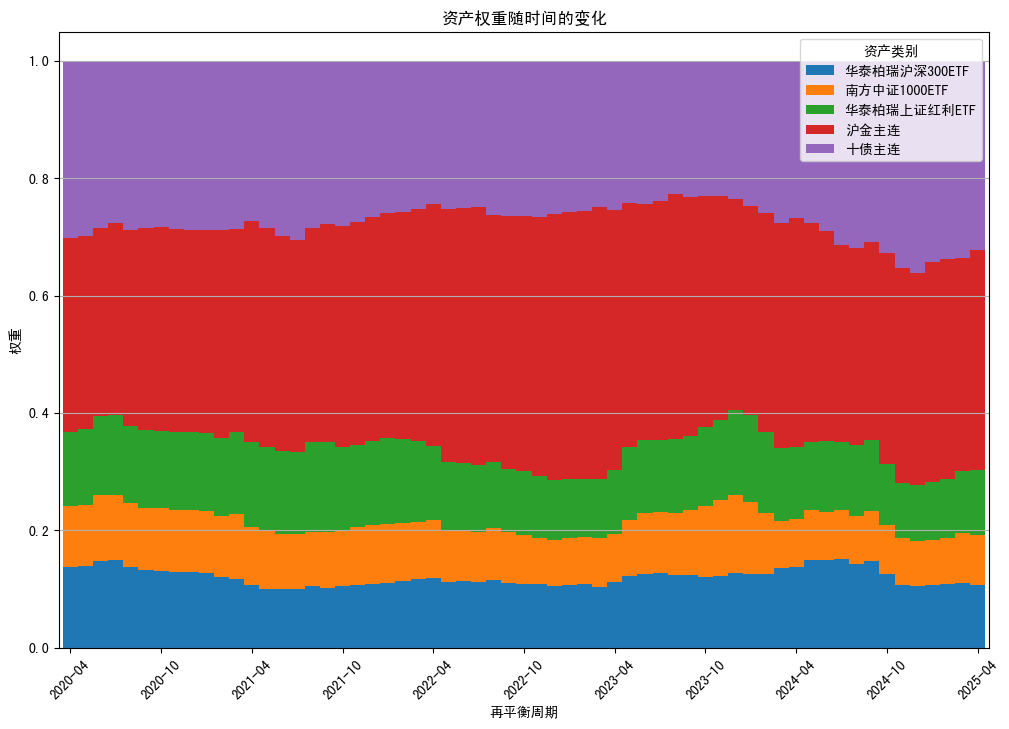

In [30]:
# 将滚动权重转换为DataFrame并设置索引为再平衡日期
rolling_weights = pd.DataFrame(rolling_weights, columns=all_log_returns.columns)
rolling_weights.index = balancing_dates

# 使用堆叠柱状图可视化资产权重随时间的变化
# Visualize the correlation matrix
plt.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

rolling_weights.plot(kind='bar', stacked=True, figsize=(12, 8), width=1)

plt.title('资产权重随时间的变化')
plt.xlabel('再平衡周期')
plt.ylabel('权重')
plt.legend(title='资产类别')
plt.grid(axis='y')

# 调整x轴刻度以显示每隔n个标签
plt.xticks(ticks=range(0, len(rolling_weights.index), 6), labels=rolling_weights.index[::6].strftime('%Y-%m'), rotation=45)

plt.show()

In [31]:
rolling_monthly_returns = pd.Series(rolling_monthly_returns, index=all_log_returns.loc[start_date:].index)

# Convert rolling cumulative returns to a pandas Series
rolling_cumulative_returns = pd.Series(
    rolling_cumulative_returns[1:],  # Exclude the initial value
    index=all_log_returns.loc[start_date: ].index  # Match index length
)

log_returns = all_log_returns.loc[start_date: ].copy()
log_returns['portfolio'] = rolling_monthly_returns

cumulative_returns_assets = (1 + log_returns).cumprod()
cumulative_returns_assets['portfolio'] = rolling_cumulative_returns

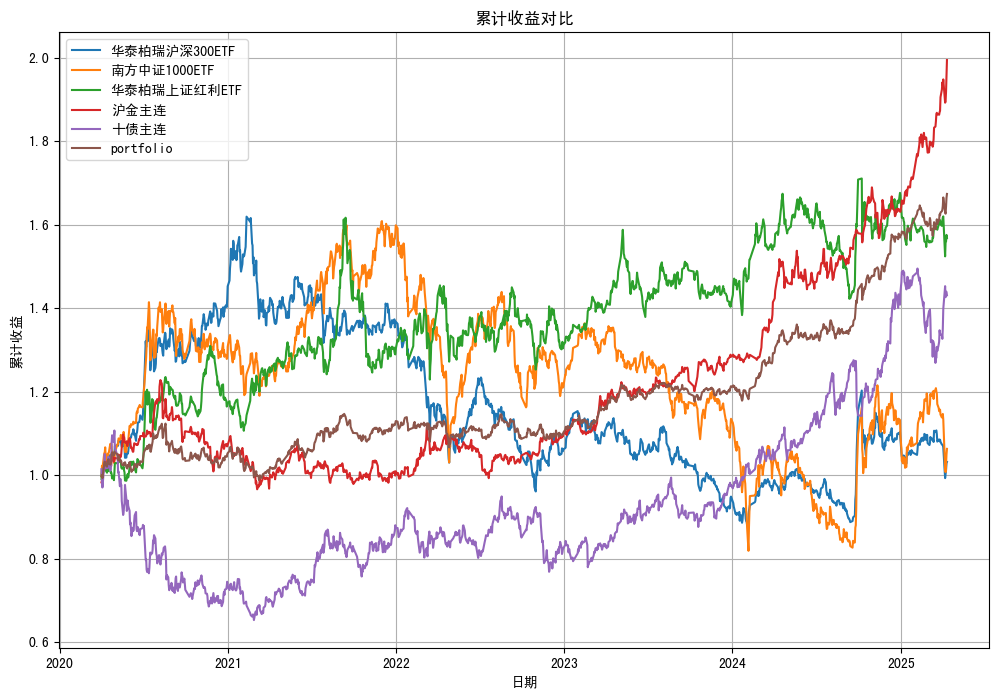

In [32]:
# 绘制每个资产类别和组合的累计收益对比图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for column in cumulative_returns_assets.columns:
    plt.plot(cumulative_returns_assets.index, cumulative_returns_assets[column], label=column)

plt.title('累计收益对比')
plt.xlabel('日期')
plt.ylabel('累计收益')
plt.legend()
plt.grid()
plt.show()

In [33]:
# 定义无风险利率（例如1.5%年化）
risk_free_rate = 0.015 / 252

# 计算每个资产和组合的绩效指标
metrics = []
for column in cumulative_returns_assets.columns:
    sharpe_ratio, max_drawdown, annualized_return, calmar_ratio = calculate_metrics(
        log_returns[column], cumulative_returns_assets[column], risk_free_rate
    )
    metrics.append({
        '资产': column,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        '年化收益': annualized_return,
        'Calmar比率': calmar_ratio
    })

# 将指标转换为DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,资产,夏普比率,最大回撤,年化收益,Calmar比率
0,华泰柏瑞沪深300ETF,0.054944,-0.456219,0.006447,0.014131
1,南方中证1000ETF,0.116291,-0.490943,0.012693,0.025854
2,华泰柏瑞上证红利ETF,0.498997,-0.239741,0.097370,0.406148
3,沪金主连,1.060047,-0.213090,0.153349,0.719645
4,十债主连,0.382797,-0.410060,0.076856,0.187427
5,portfolio,1.011836,-0.120584,0.112302,0.931320
